In [1]:
import mmcci

/Users/leviho/micromamba/envs/py-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load stLearn data objects

In [2]:
import pickle

with open('data/brain_data.pkl', 'rb') as f:
    brain_data = pickle.load(f)

In [3]:
samples = []

for i in range(4):
    samples.append(mmcci.CCIData(
        cci_scores=brain_data['brain_aged_tech1_cci'][i],
        p_values=brain_data['brain_aged_tech1_pvals'][i],
        n_spots=brain_data['brain_aged_tech1_sizes'][i],
        platform='tech1',
        other_metadata={'age': 'aged'}
        ))
    
for i in range(4):
    samples.append(mmcci.CCIData(
        cci_scores=brain_data['brain_young_tech1_cci'][i],
        p_values=brain_data['brain_young_tech1_pvals'][i],
        n_spots=brain_data['brain_young_tech1_sizes'][i],
        platform='tech1',
        other_metadata={'age': 'young'}
        ))
    
for i in range(2):
    samples.append(mmcci.CCIData(
        cci_scores=brain_data['brain_aged_tech2_cci'][i],
        p_values=brain_data['brain_aged_tech2_pvals'][i],
        n_spots=brain_data['brain_aged_tech2_sizes'][i],
        platform='tech2',
        other_metadata={'age': 'aged'}
        ))
    
for i in range(2):
    samples.append(mmcci.CCIData(
        cci_scores=brain_data['brain_young_tech2_cci'][i],
        p_values=brain_data['brain_young_tech2_pvals'][i],
        n_spots=brain_data['brain_young_tech2_sizes'][i],
        platform='tech2',
        other_metadata={'age': 'young'}
        ))

In [4]:
from matplotlib import pyplot as plt

colors = {
    'Ependymal': plt.colormaps.get_cmap('tab10').colors[0],
    'Astrocytes': plt.colormaps.get_cmap('tab10').colors[1],
    'Vascular': plt.colormaps.get_cmap('tab10').colors[2],
    'Oligos': plt.colormaps.get_cmap('tab10').colors[3],
    'Neurons': plt.colormaps.get_cmap('tab10').colors[4],
    'Microglia': plt.colormaps.get_cmap('tab10').colors[5],
    'Immune': plt.colormaps.get_cmap('tab10').colors[6],
    'PeripheralGlia': plt.colormaps.get_cmap('tab10').colors[7],
}

#### Normalise each group of samples

In [5]:
for i in range(len(samples)):
    samples[i] = samples[i].scale_by_nspots()
    samples[i] = samples[i].filter_by_p_vals(assay='scaled')
    samples[i] = samples[i].calc_overall(assay='filtered')
    # mmcci.plt.network_plot(samples[i].assays['filtered']['overall'], node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors, show_labels=False)

#### Integrate within technologies

In [6]:
brain_aged_tech1_integrated = mmcci.it.lr_integration(samples[0:4], method=">=50%", strict=True, assay="scaled", metadata={'platform': 'tech1'})
brain_young_tech1_integrated = mmcci.it.lr_integration(samples[4:8], method=">=50%", strict=True, assay="scaled", metadata={'platform': 'tech1'})
brain_aged_tech2_integrated = mmcci.it.lr_integration(samples[8:10], method=">=50%", strict=True, assay="scaled", metadata={'platform': 'tech2'})
brain_young_tech2_integrated = mmcci.it.lr_integration(samples[10:12], method=">=50%", strict=True, assay="scaled", metadata={'platform': 'tech2'})

Integrating p values: 100%|██████████| 1253/1253 [00:08<00:00, 143.65it/s]


In [7]:
brain_aged_tech1_integrated = brain_aged_tech1_integrated.filter_by_p_vals().calc_overall(assay='filtered')
brain_young_tech1_integrated = brain_young_tech1_integrated.filter_by_p_vals().calc_overall(assay='filtered')
brain_aged_tech2_integrated = brain_aged_tech2_integrated.filter_by_p_vals().calc_overall(assay='filtered')
brain_young_tech2_integrated = brain_young_tech2_integrated.filter_by_p_vals().calc_overall(assay='filtered')

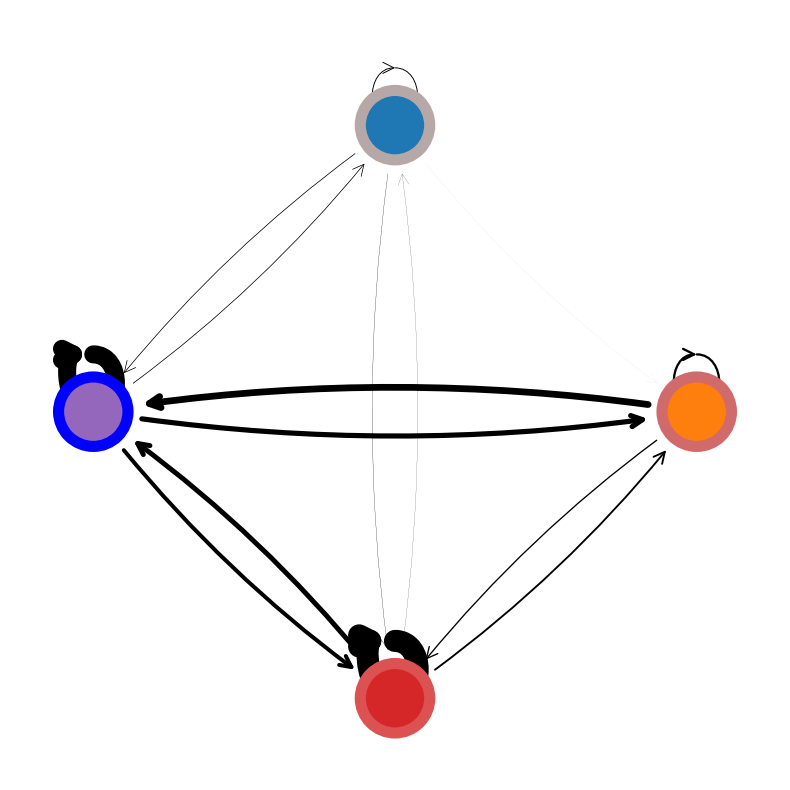

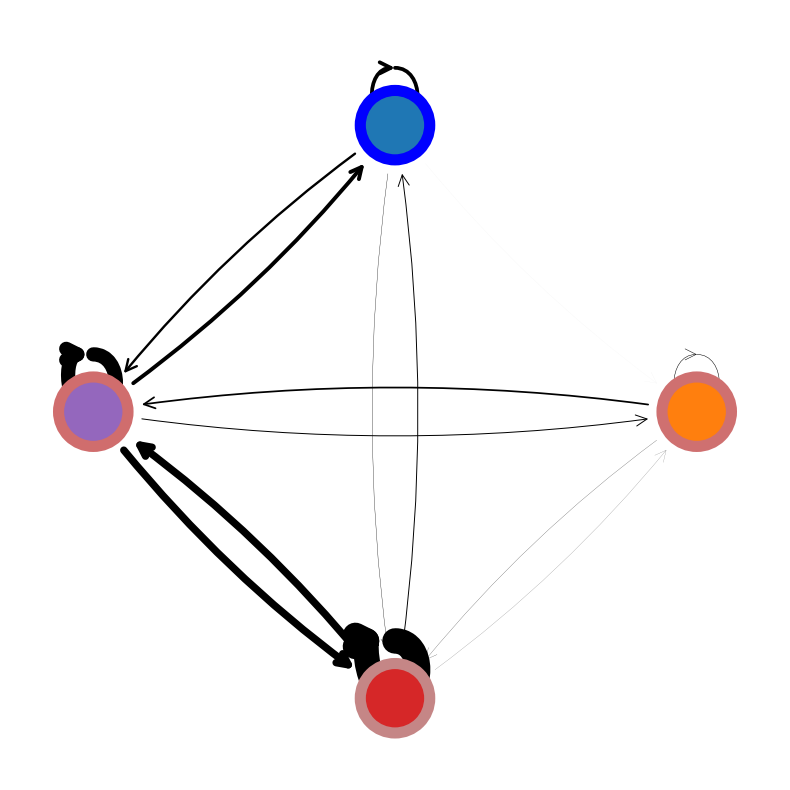

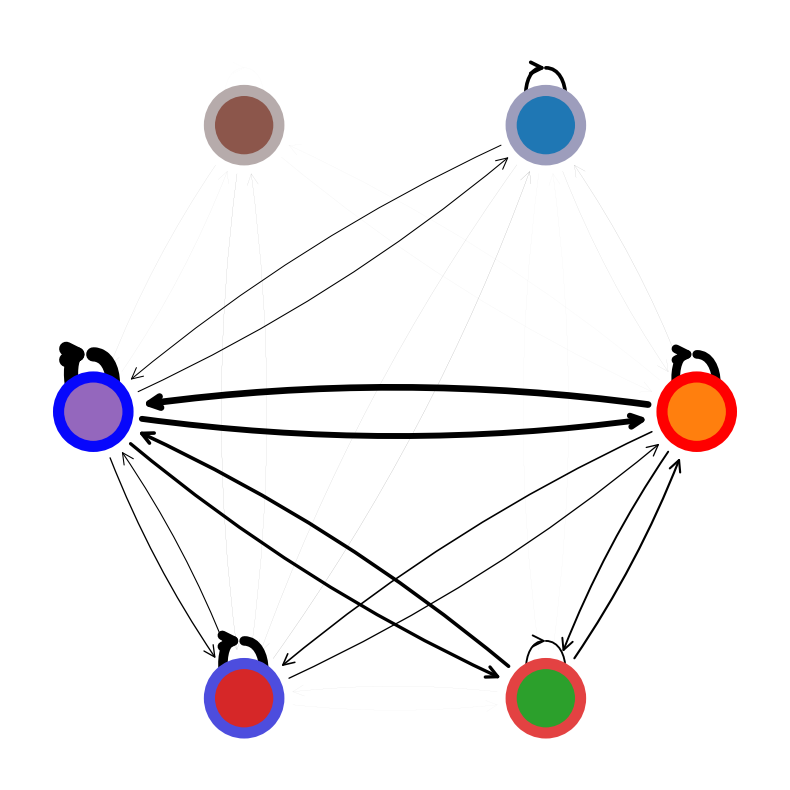

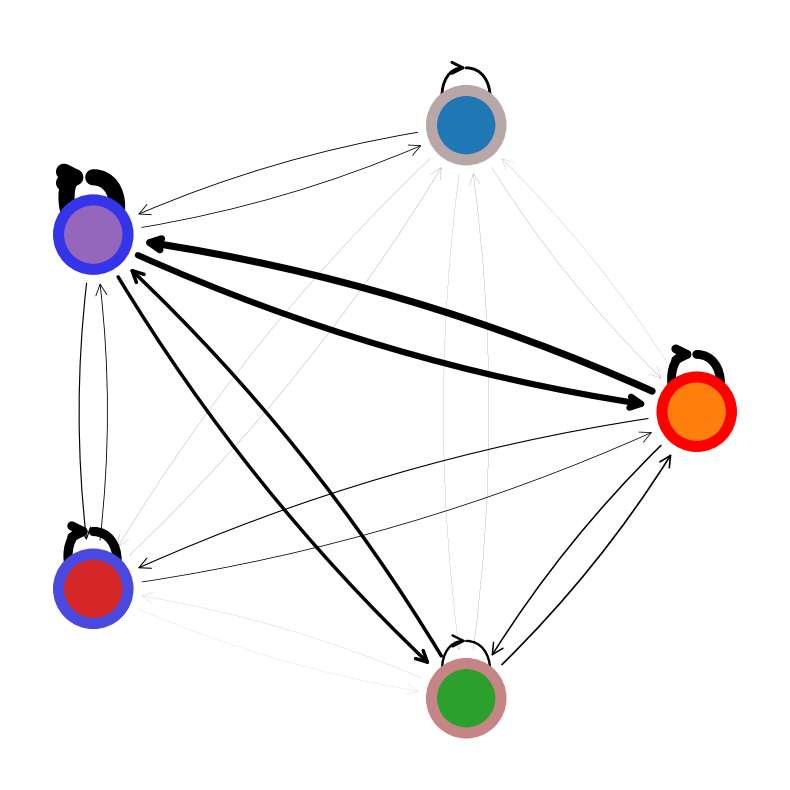

In [8]:
mmcci.plt.network_plot(brain_aged_tech1_integrated.assays['filtered']['overall'], node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors, show_labels=False)
mmcci.plt.network_plot(brain_young_tech1_integrated.assays['filtered']['overall'], node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors, show_labels=False)
mmcci.plt.network_plot(brain_aged_tech2_integrated.assays['filtered']['overall'], node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors, show_labels=False)
mmcci.plt.network_plot(brain_young_tech2_integrated.assays['filtered']['overall'], node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors, show_labels=False)

#### Normalise samples between technologies

In [9]:
aged_scale_factors = mmcci.it.calc_scale_factors([brain_aged_tech1_integrated, brain_aged_tech2_integrated], assay='raw')
young_scale_factors = mmcci.it.calc_scale_factors([brain_young_tech1_integrated, brain_young_tech2_integrated], assay='raw')

brain_aged_tech1_integrated = brain_aged_tech1_integrated.scale(aged_scale_factors['tech1'], assay='raw')
brain_young_tech1_integrated = brain_young_tech1_integrated.scale(young_scale_factors['tech1'], assay='raw')
brain_aged_tech2_integrated = brain_aged_tech2_integrated.scale(aged_scale_factors['tech2'], assay='raw')
brain_young_tech2_integrated = brain_young_tech2_integrated.scale(young_scale_factors['tech2'], assay='raw')

#### Integrate between technologies for both groups

In [10]:
aged_integrated = mmcci.it.lr_integration([brain_aged_tech1_integrated, brain_aged_tech2_integrated], method=">50%", strict=True, assay="scaled", metadata={'age': 'aged'})
young_integrated = mmcci.it.lr_integration([brain_young_tech1_integrated, brain_young_tech2_integrated], method=">50%", strict=True, assay="scaled", metadata={'age': 'young'})

Integrating p values: 100%|██████████| 1294/1294 [00:07<00:00, 162.01it/s]


In [11]:
aged_integrated = aged_integrated.filter_by_p_vals().calc_overall(assay='filtered')
young_integrated = young_integrated.filter_by_p_vals().calc_overall(assay='filtered')

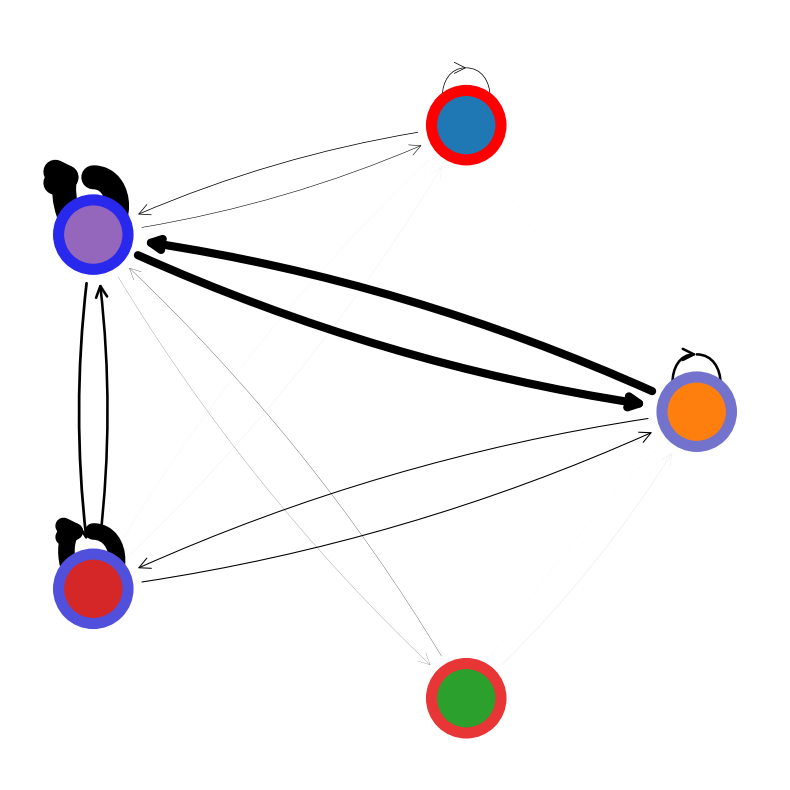

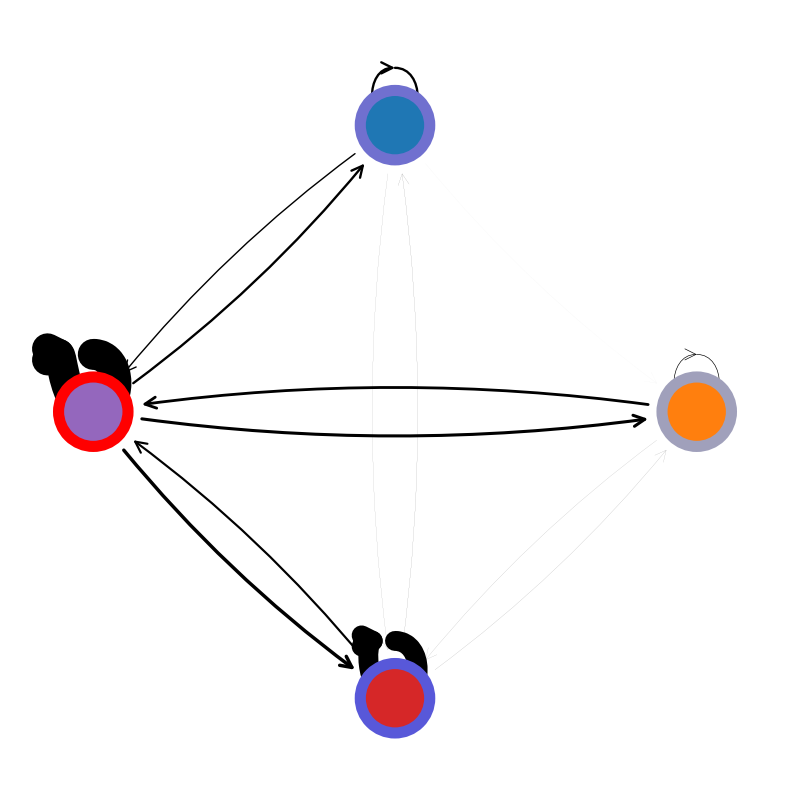

In [12]:
mmcci.plt.network_plot(aged_integrated.assays['filtered']['overall'], node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors, show_labels=False)
mmcci.plt.network_plot(young_integrated.assays['filtered']['overall'], node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors, show_labels=False)

#### Rank LR pairs based on dissimilarity between groups

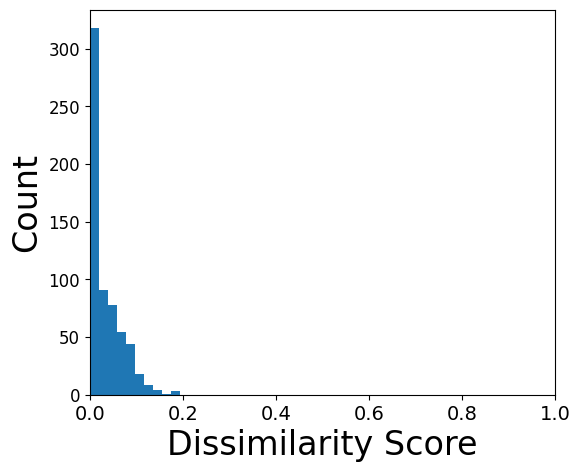

Overall Network Aged vs Young Dissimilarity Score is: 0.23290906762113986


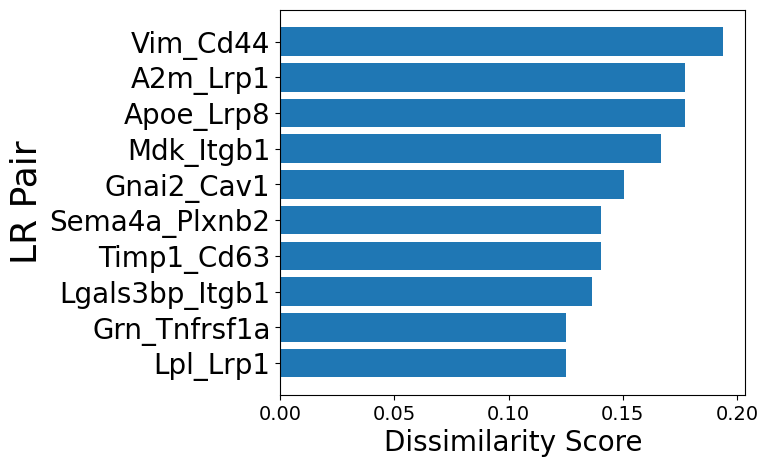

In [13]:
dissimilarity_scores = mmcci.an.calculate_dissim(aged_integrated, young_integrated, assay='filtered')
mmcci.plt.dissim_hist(dissimilarity_scores)
    
## Sort LR Pairs from high to low dissimilarities
print("Overall Network Aged vs Young Dissimilarity Score is: " + str(mmcci.sc.dissimilarity_score(aged_integrated.assays['filtered']['overall'], young_integrated.assays['filtered']['overall'])))

mmcci.plt.lr_top_dissimilarity(dissimilarity_scores, x_label_size=20, y_label_size=26, y_tick_size=20, figsize=(6,5))

#### Plot highly dissimilar pairs between groups

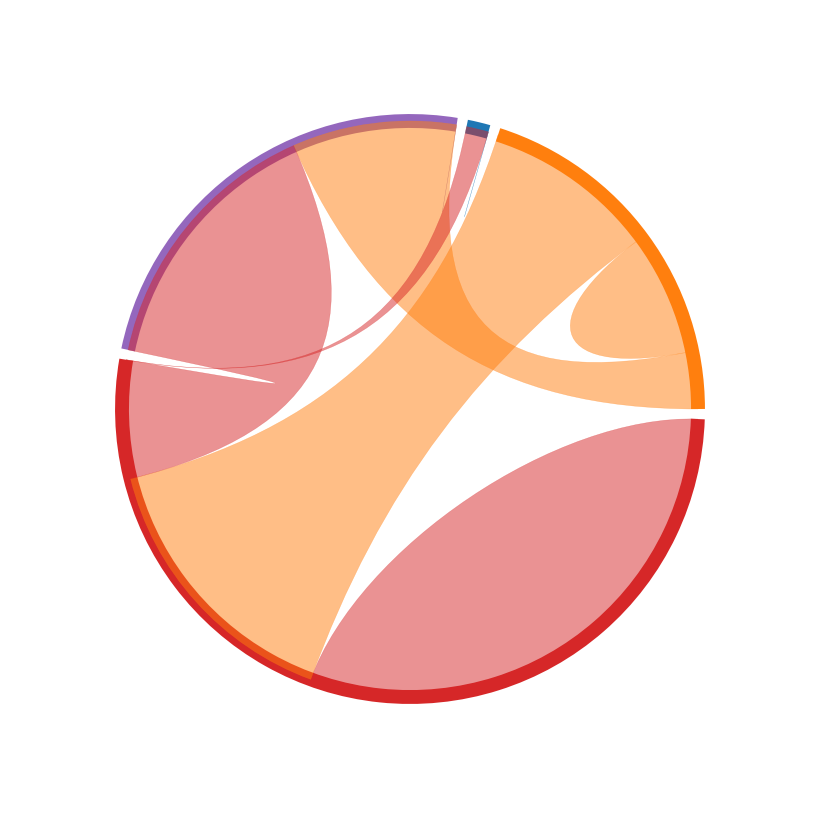

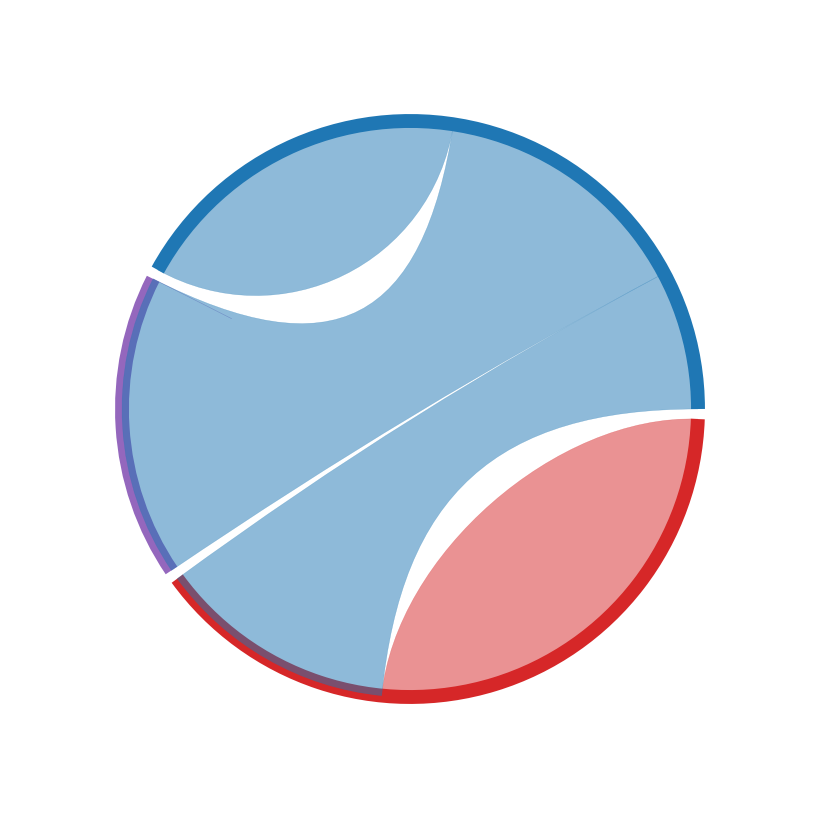

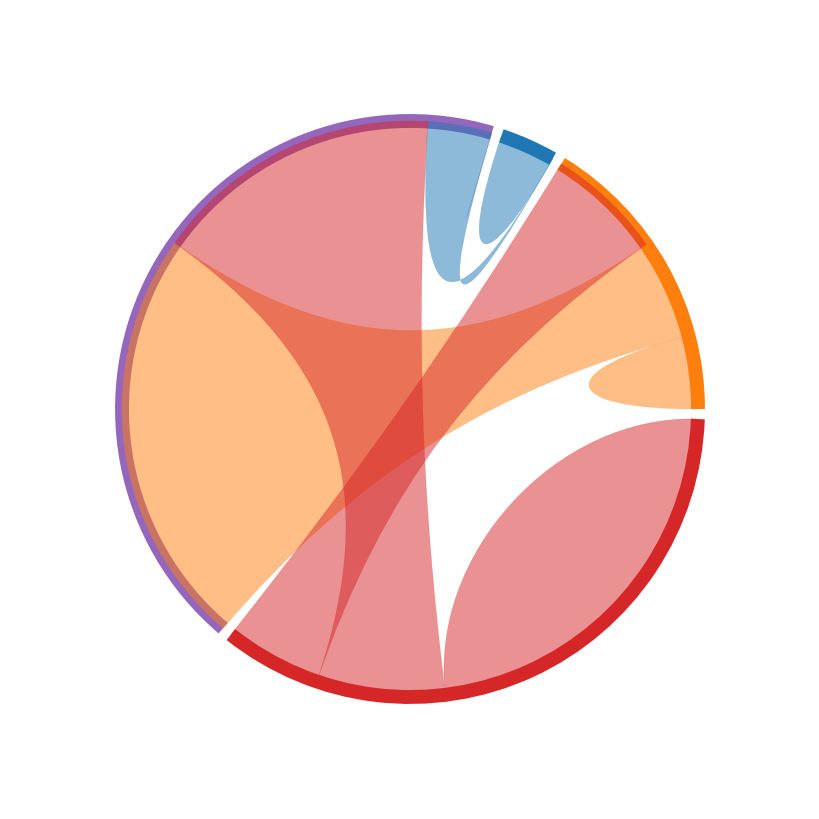

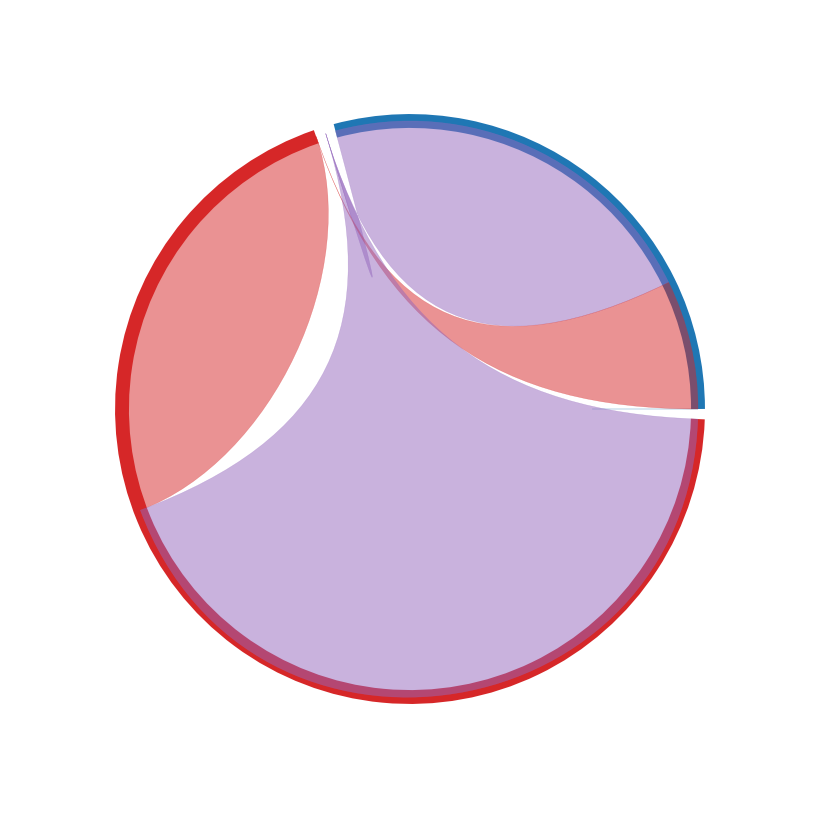

In [14]:
mmcci.plt.chord_plot(aged_integrated.assays['filtered']['cci_scores']['Vim_Cd44'], colors=colors, label_size=0)
mmcci.plt.chord_plot(young_integrated.assays['filtered']['cci_scores']['Vim_Cd44'], colors=colors, label_size=0)

mmcci.plt.chord_plot(aged_integrated.assays['filtered']['cci_scores']['A2m_Lrp1'], colors=colors, label_size=0)
mmcci.plt.chord_plot(young_integrated.assays['filtered']['cci_scores']['A2m_Lrp1'], colors=colors, label_size=0)

#### Calculate p values for significance changes between groups

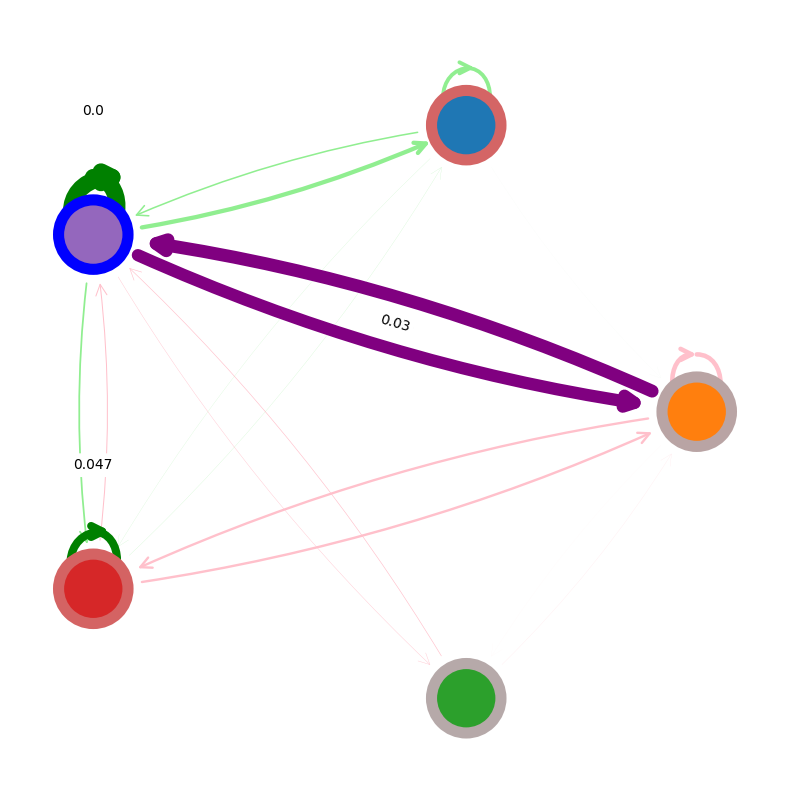

In [15]:
age_diff = mmcci.an.get_network_diff(aged_integrated.assays['filtered']['overall'], young_integrated.assays['filtered']['overall'])
mmcci.plt.network_plot(age_diff['diff'], age_diff['p_vals'], diff_plot=True, show_labels=False, node_size=2500, edge_weight=120, figsize=(8,8), node_colors=colors)

#### Get LR pairs from Astrocytes to Neurons

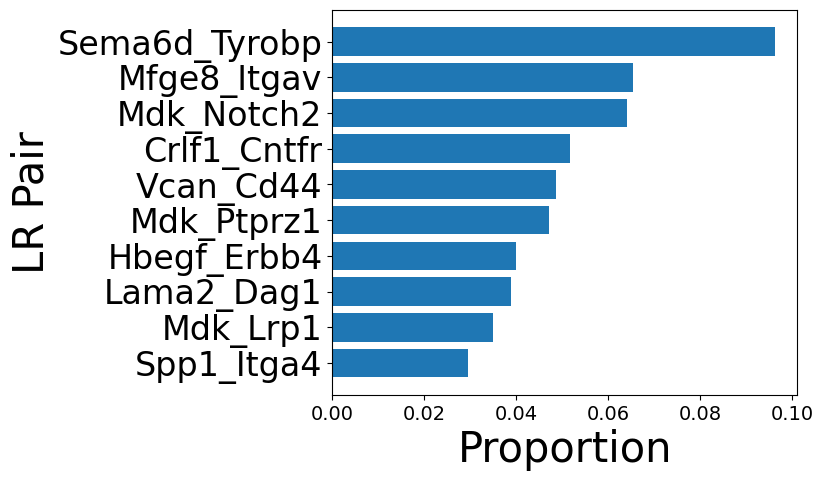

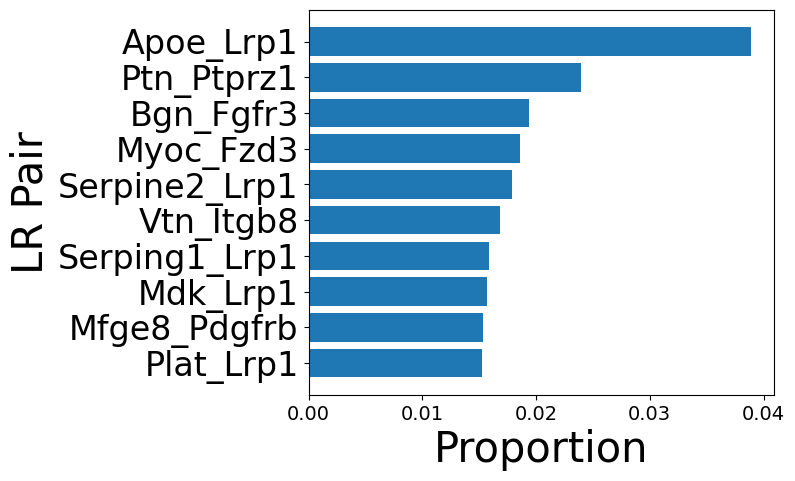

In [16]:
mmcci.plt.lrs_per_celltype(young_integrated, "Astrocytes", "Neurons", assay='filtered', n=10, x_label_size=30, y_label_size=30, y_tick_size=24, figsize=(6,5))
mmcci.plt.lrs_per_celltype(aged_integrated, "Astrocytes", "Neurons", assay='filtered', n=10, x_label_size=30, y_label_size=30, y_tick_size=24, figsize=(6,5))

#### Cluster Aged and Young LR Pairs

Computing Dissimilarity Scores for multiple interactions...


Processing: 100%|██████████| 374/374 [00:37<00:00,  9.94it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...
Computing Dissimilarity Scores for single interactions...


Processing: 100%|██████████| 254/254 [00:17<00:00, 14.63it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...


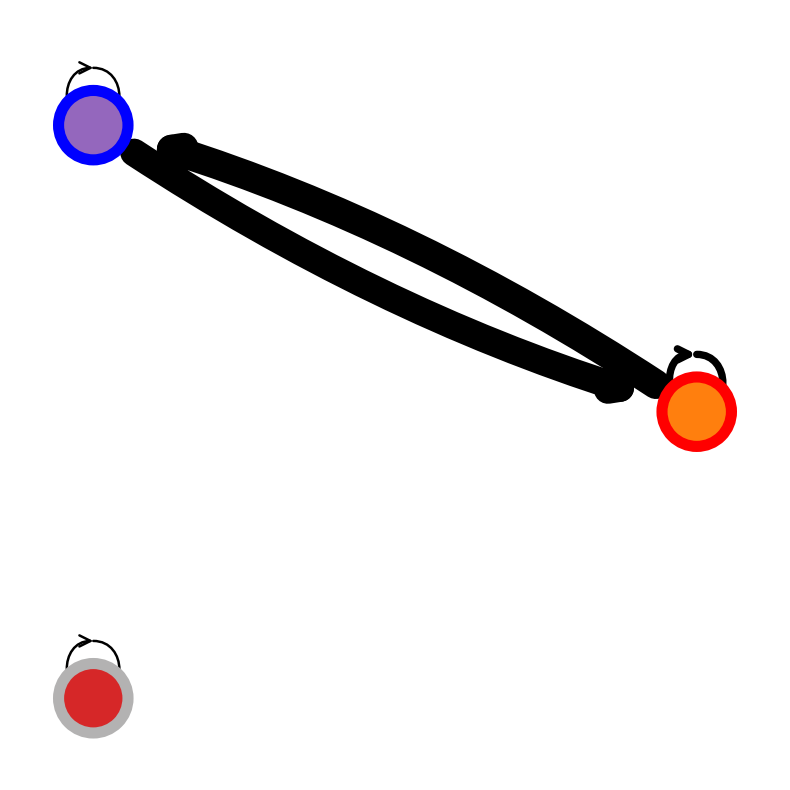

In [17]:
aged_integrated = mmcci.an.cell_network_clustering(aged_integrated, assay='filtered', n_clusters=0)
mmcci.plt.network_plot(aged_integrated.assays['cluster_0']['overall'], node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors, show_labels=False)

In [19]:
aged_integrated.assays.keys()

dict_keys(['raw', 'filtered', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11'])

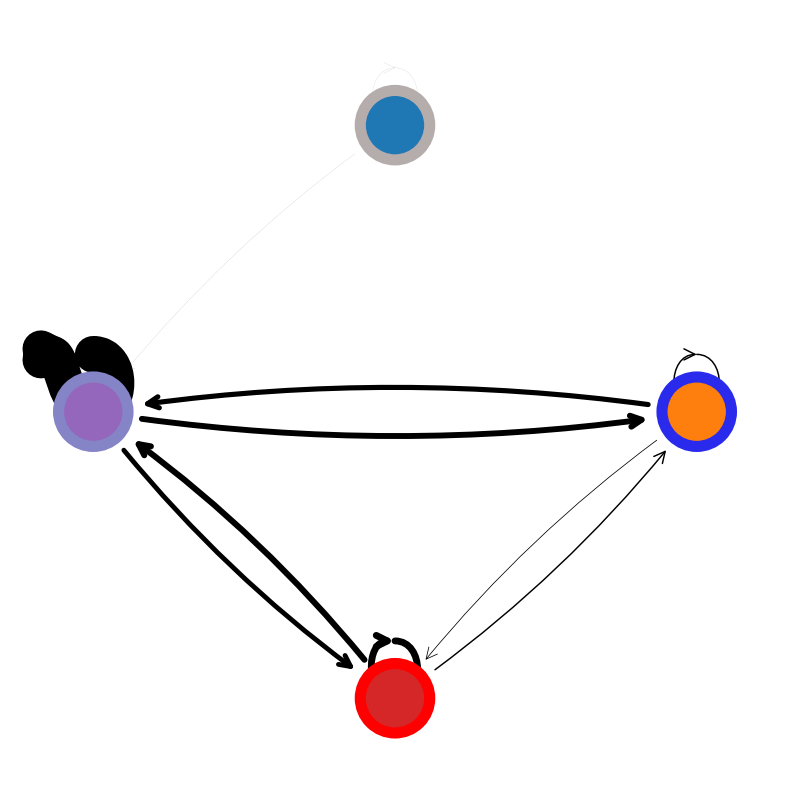

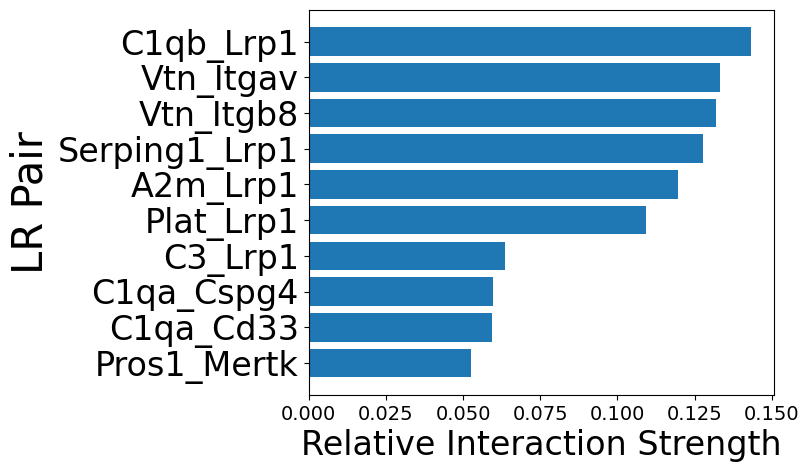

In [32]:
results = mmcci.an.run_gsea(aged_integrated, organism="mouse", gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"], show_plots=False)
grouped = mmcci.an.pathway_subset(aged_integrated, results, ["Complement and coagulation cascades"], strict=False)
grouped_overall = mmcci.it.calculate_overall_interactions(grouped)
mmcci.plt.network_plot(grouped_overall, node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors, show_labels=False)
mmcci.plt.lr_barplot(grouped, n=10, x_label_size=24, y_label_size=30, y_tick_size=24, figsize=(6,5))